In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
from IPython.display import display, Latex
from datetime import datetime
import os
from scipy import signal

%matplotlib notebook 

## PROBLEM 1

We want to see the broken default random number generator in the C standard library. If we generate (x,y,z) coordinates, for "true" random numbers, we should see uniformly dispersed points with no underlying pattern. Hence, if we generate (x,y,z) random numbers from the C library and observe a pattern as we plot them, it is evident that the default C library's PRNG is flawed!

<IPython.core.display.Javascript object>


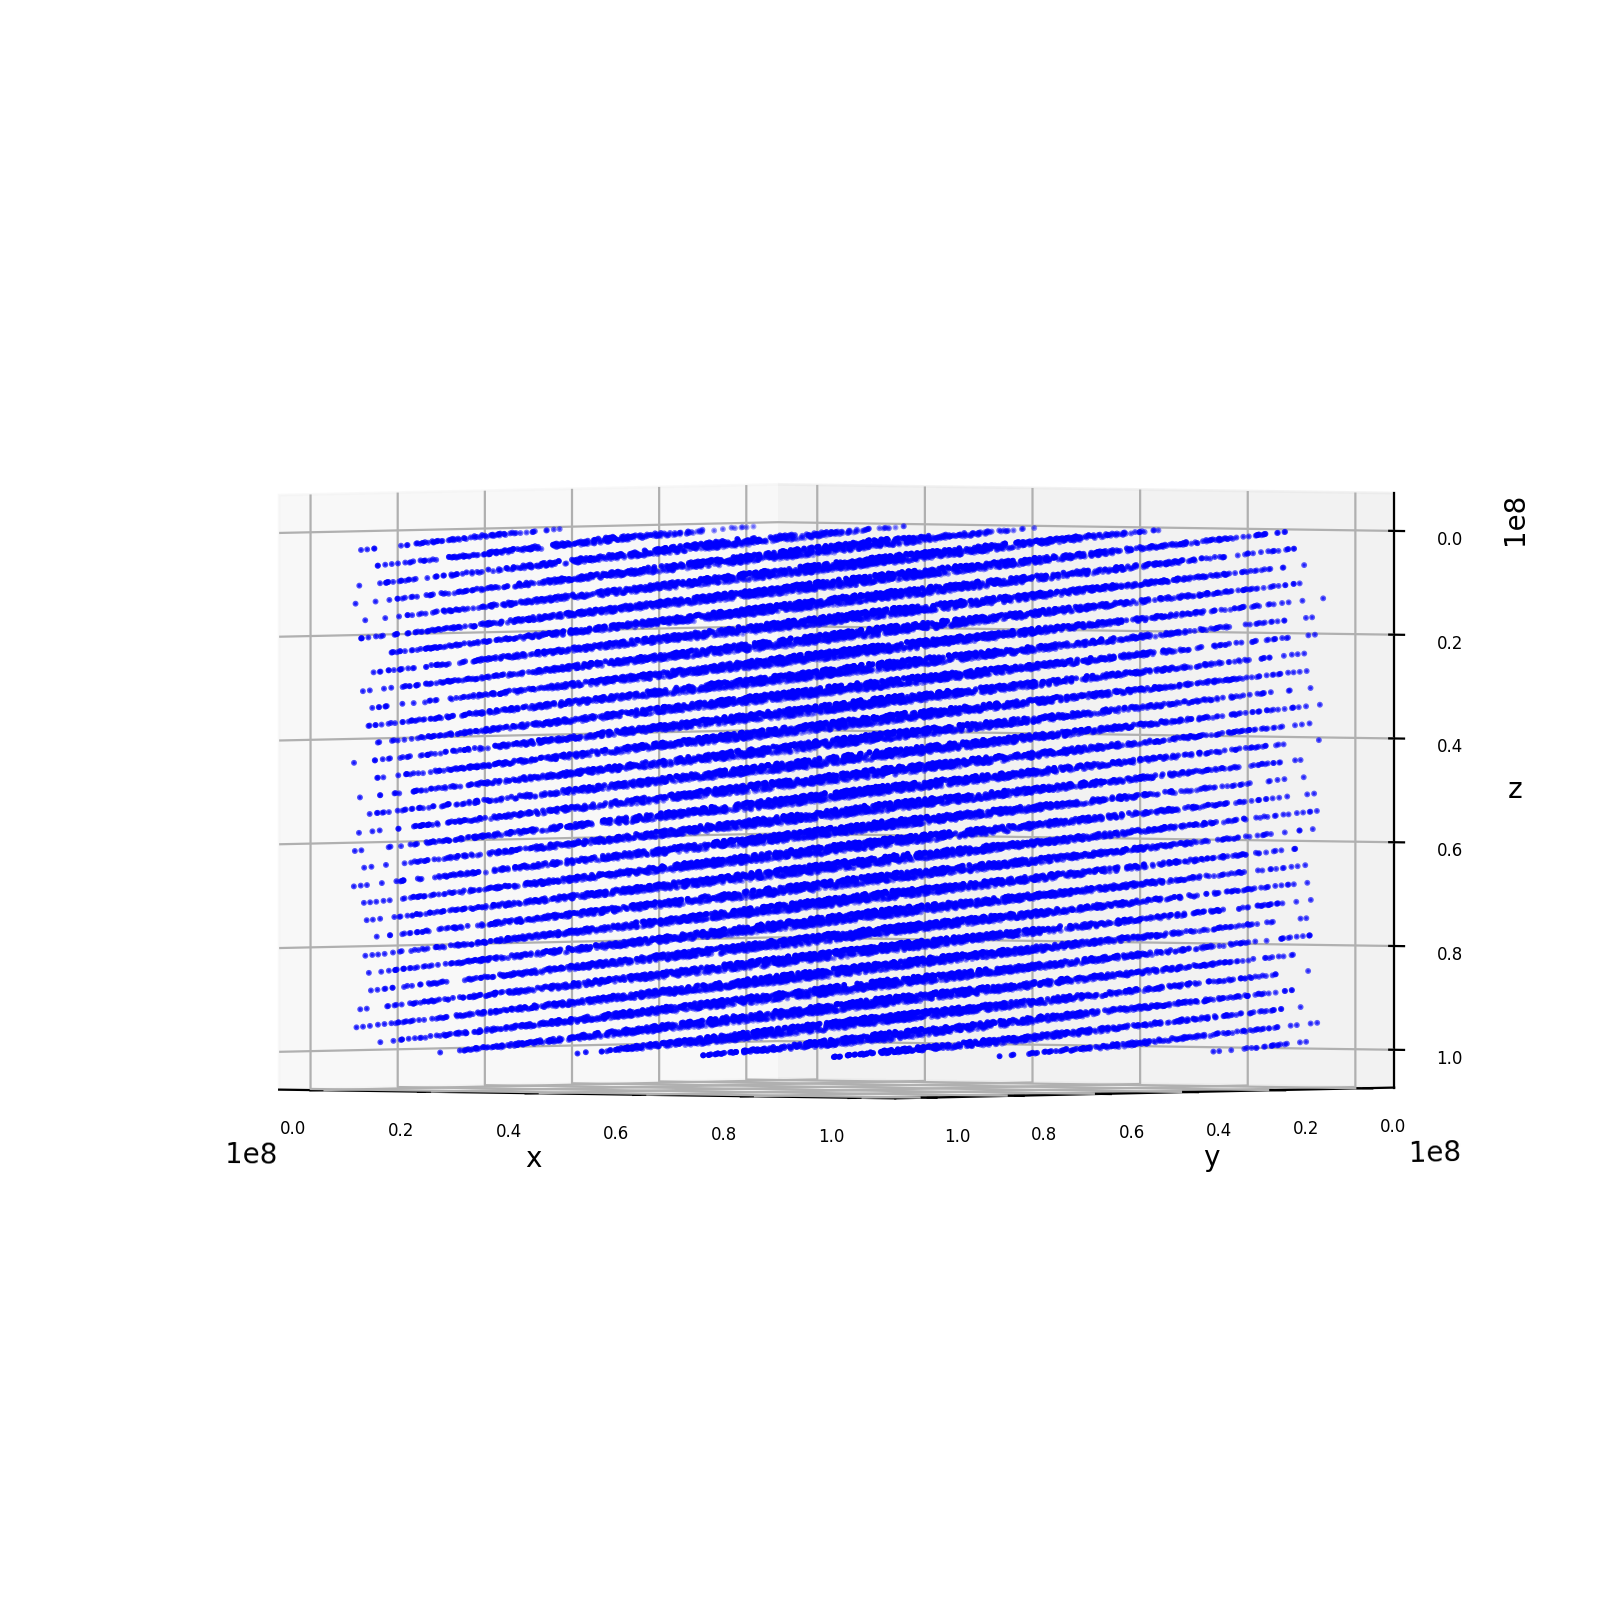

In [2]:
rand_points = np.loadtxt('rand_points.txt') #download random points from C library

fig = plt.figure()
ax = plt.axes(projection='3d',proj_type = 'ortho')
ax.scatter3D(rand_points[:,0], rand_points[:,1], rand_points[:,2],marker='.',color='blue',s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.view_init(-179,-129)
fig.set_size_inches(8,8)

<IPython.core.display.Javascript object>


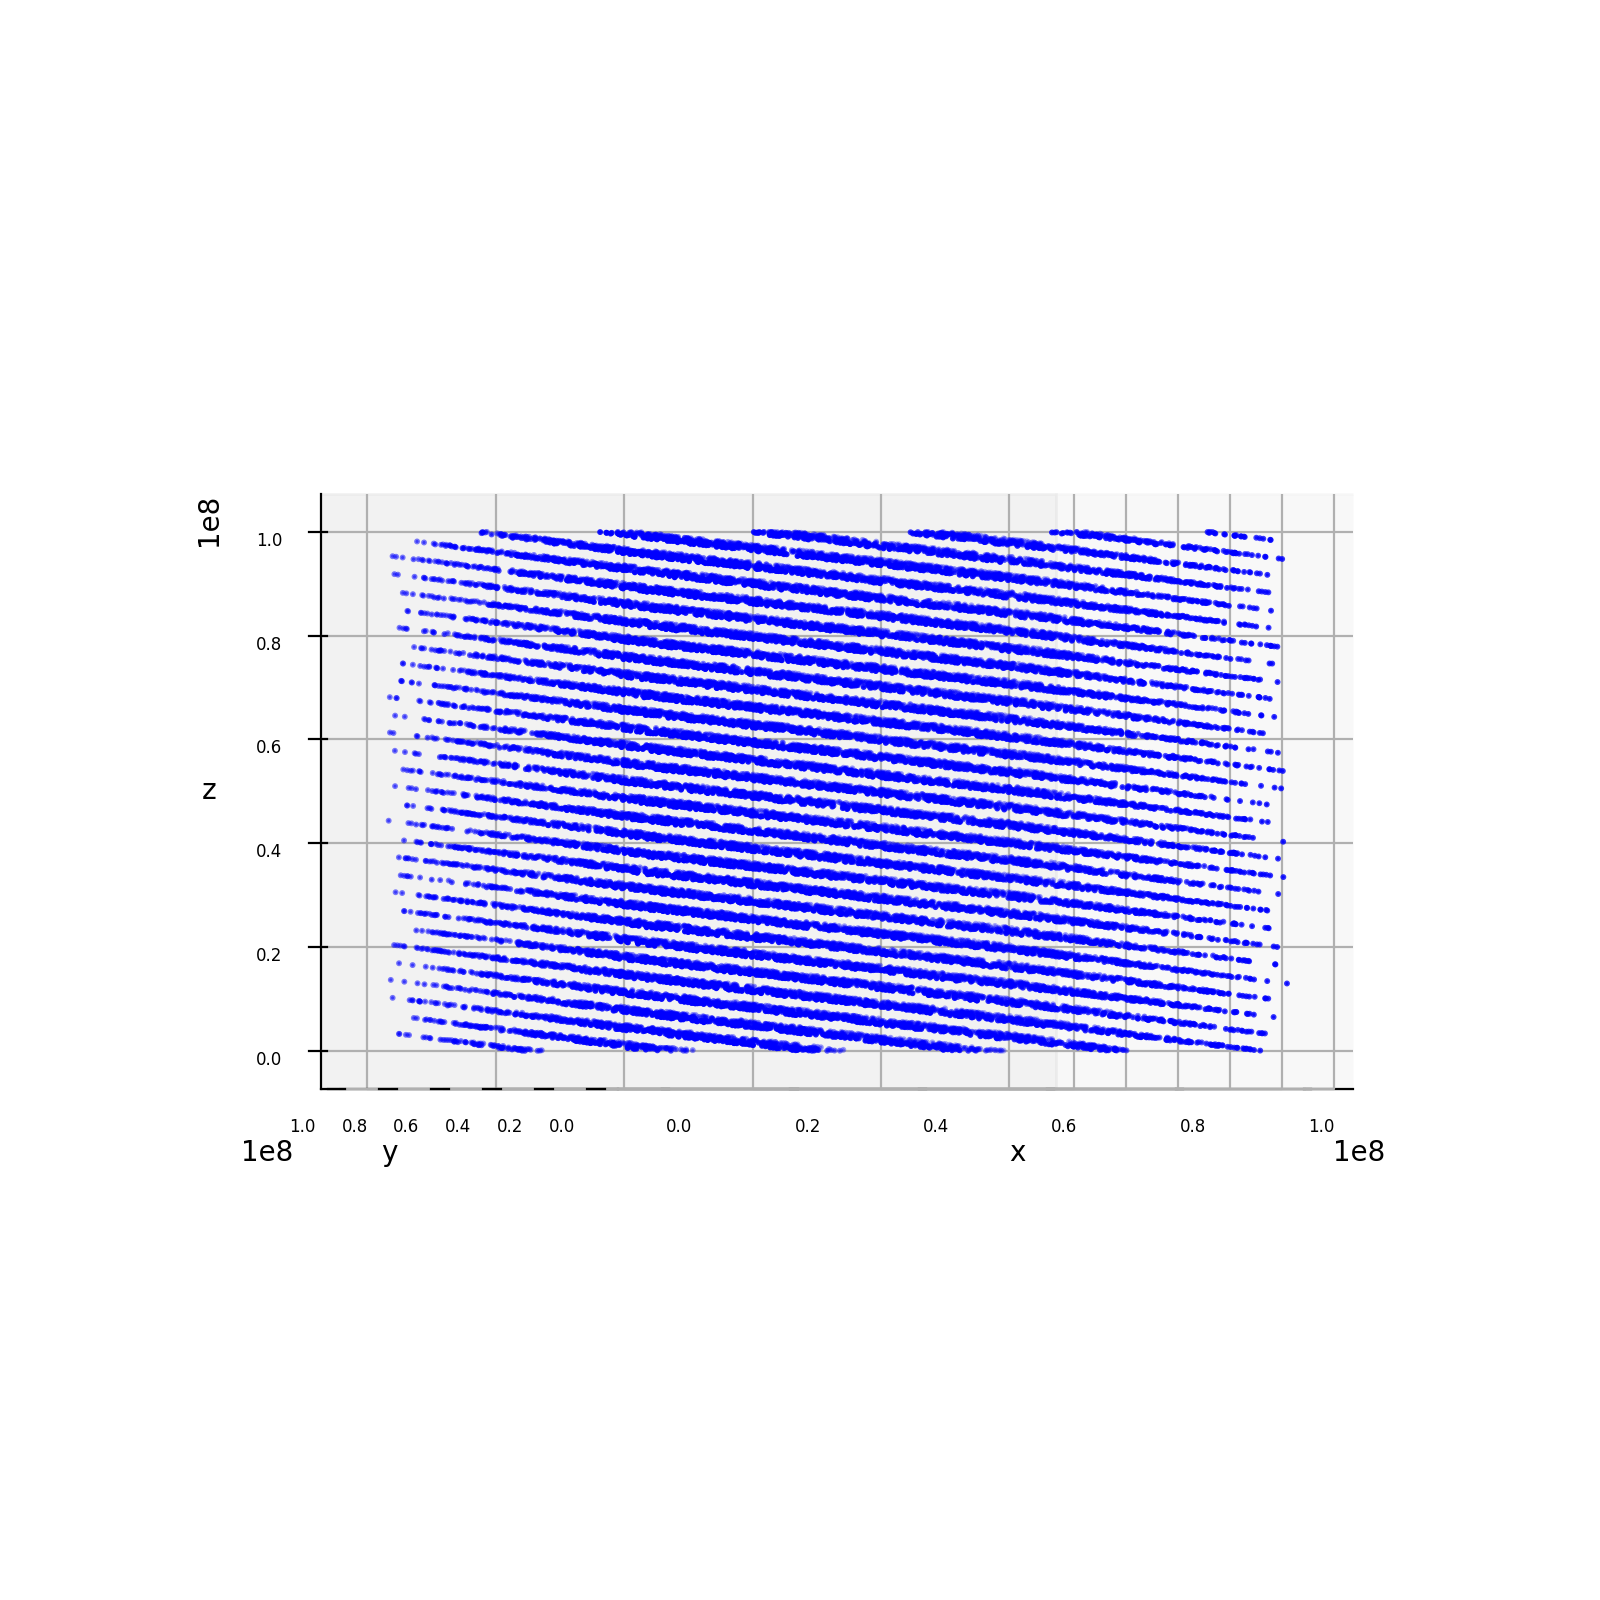

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d',proj_type = 'ortho')
ax.scatter3D(rand_points[:,0], rand_points[:,1], rand_points[:,2],marker='.',color='blue',s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.view_init(0,-112)
fig.set_size_inches(8,8)


<IPython.core.display.Javascript object>


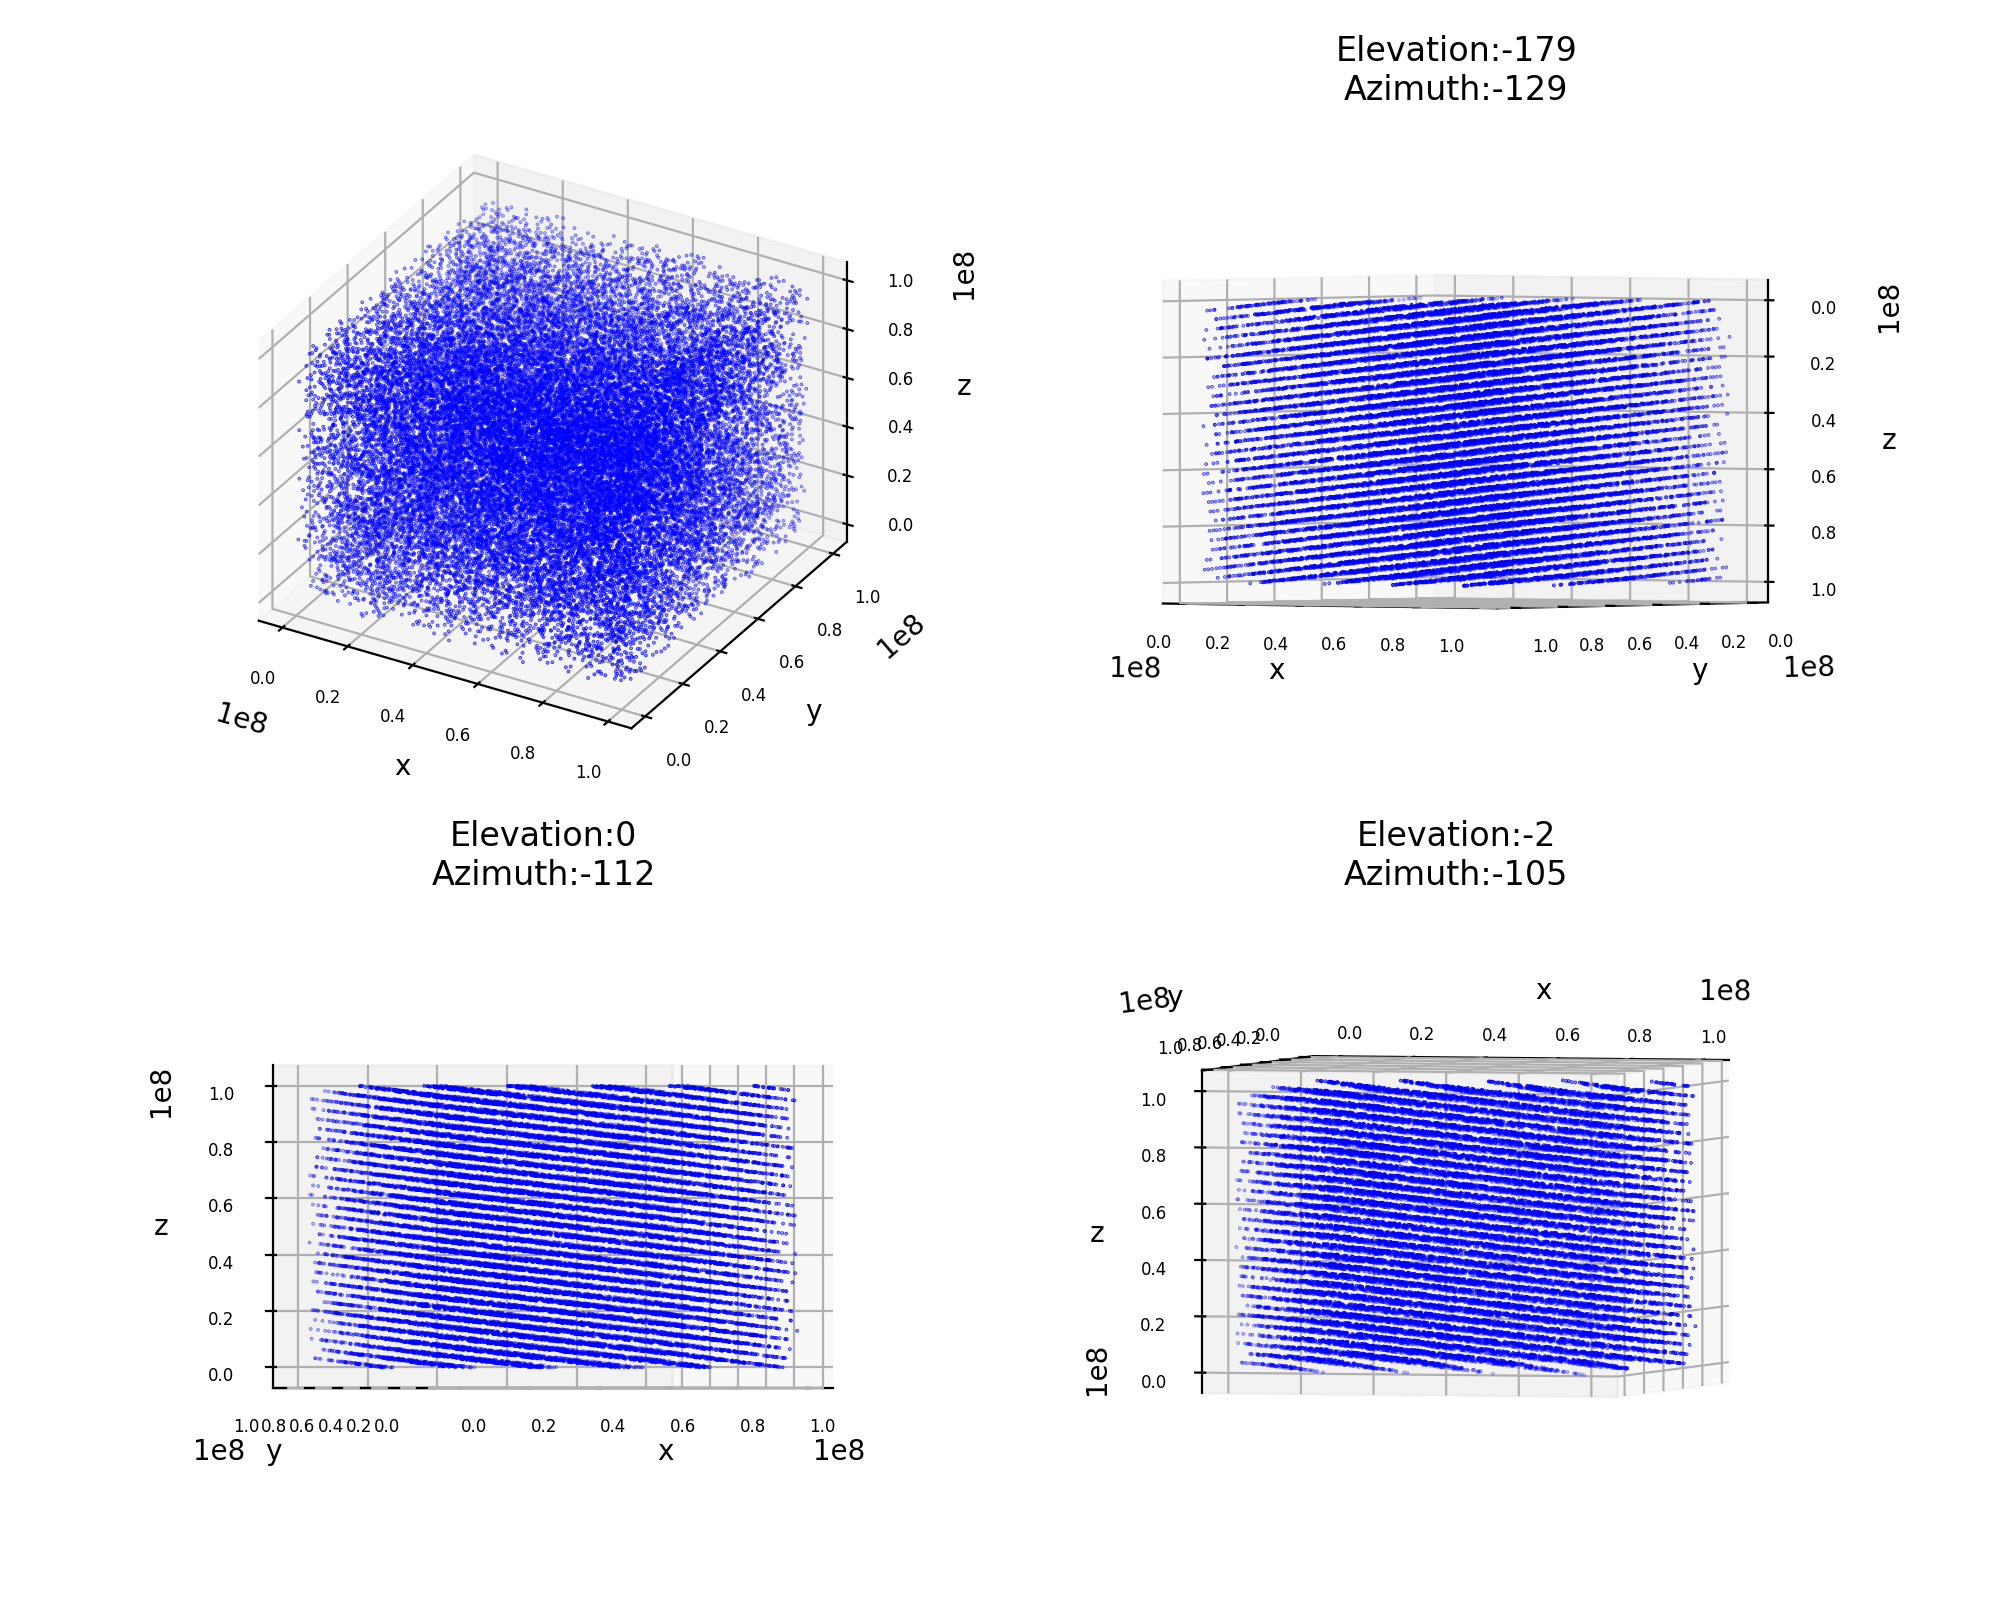

In [4]:
angles = [[-179,-129],[0,-112],[-2,-105]]
fig = plt.figure()
pos = [221,222,223,224]
for i in range(4):
    ax=fig.add_subplot(pos[i],projection='3d',proj_type = 'ortho')
    ax.scatter3D(rand_points[:,0], rand_points[:,1], rand_points[:,2],marker='.',color='blue',s=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.tick_params(axis='both', which='major', labelsize=6)
    if i!=0:
        ax.view_init(angles[i-1][0],angles[i-1][1])
        ax.set_title('Elevation:{}\nAzimuth:{}'.format(angles[i-1][0],angles[i-1][1]))


fig.set_size_inches(10,8)
fig.tight_layout()

From the three examples shown above with different elevation and azimuthal angles, it is obvious to see from the set of planes (about 30) that the triples are very not much randomly distributed in 3D space!

We can also view this by plotting plane projections i.e. $(ax+by,z)$ by chosing suitable $a,b$. Below shows the projection for $a=1$ and $b=0.5$, which again shows that the triples are very far from being randomly distributed viewed like this.

<IPython.core.display.Javascript object>


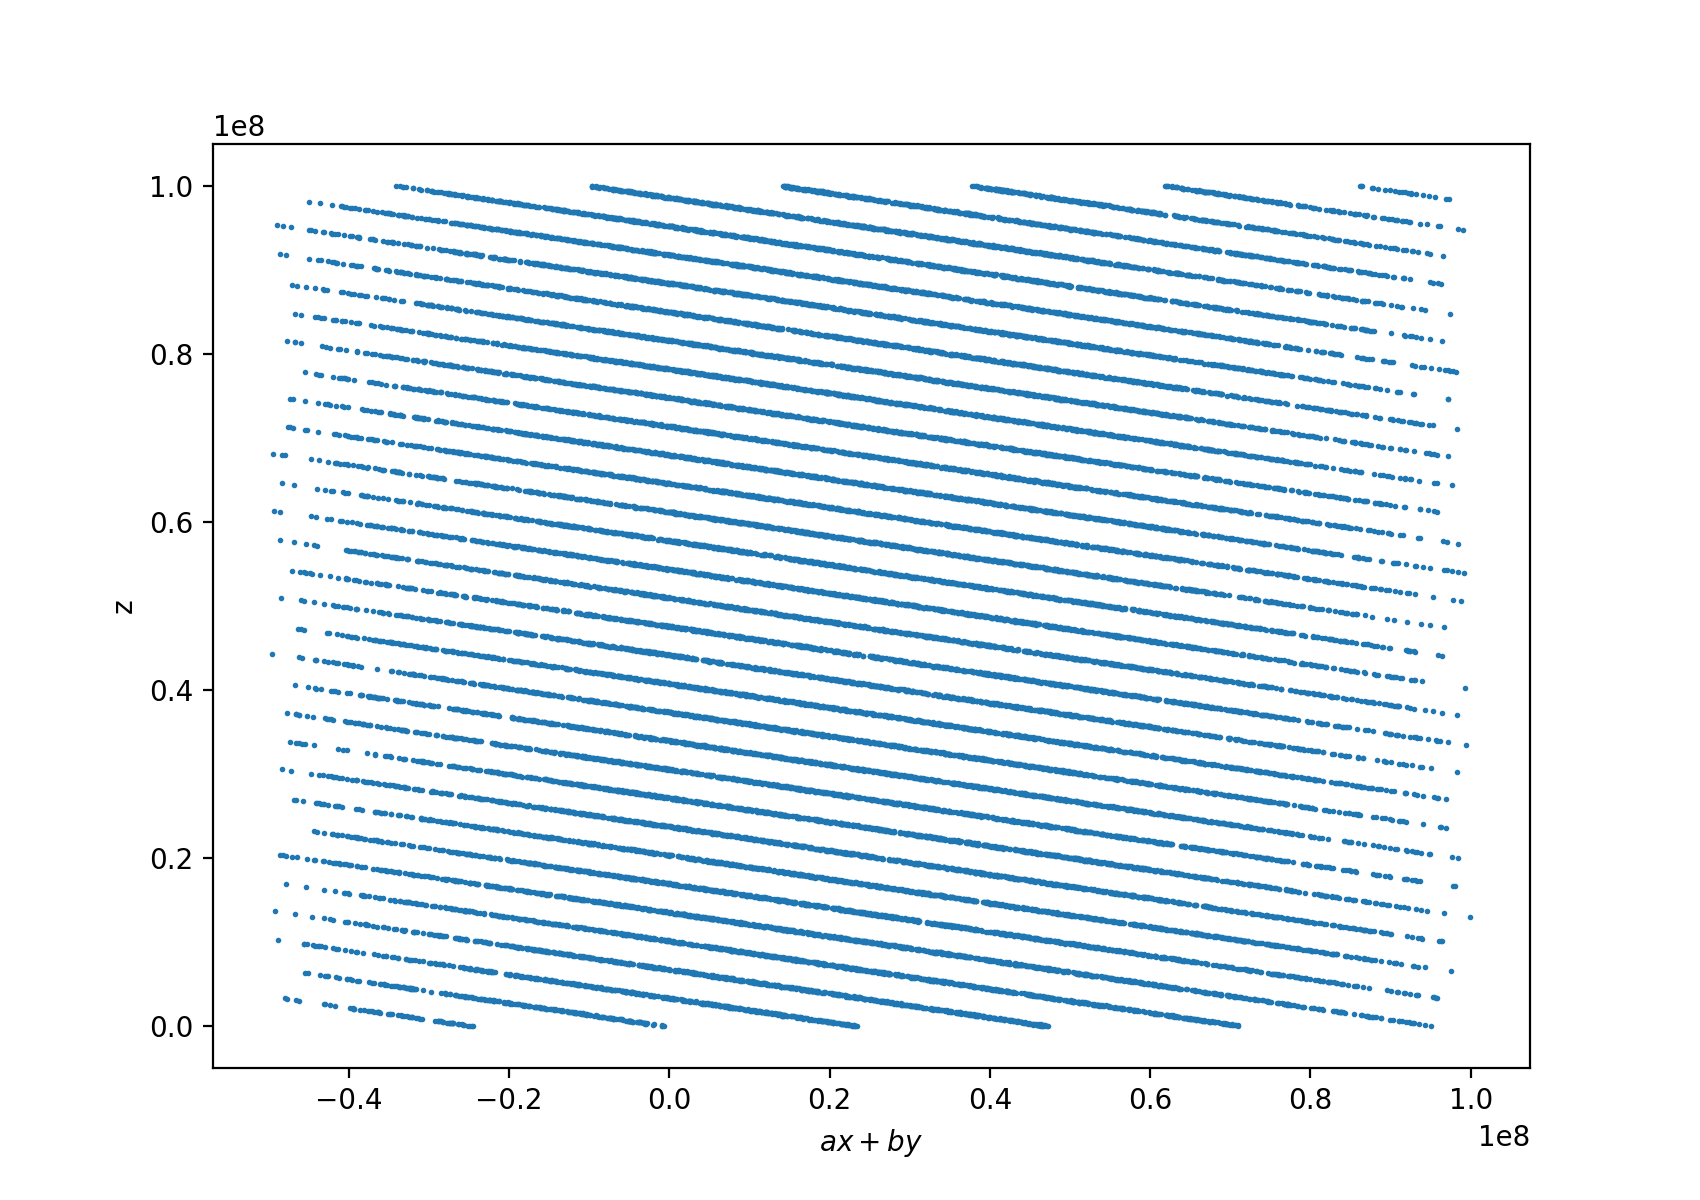

In [5]:
#We can also view this by plotting a projection with suitable a,b 
a=1
b=-0.5
fig=plt.figure()
plt.plot(a*rand_points[:,0]+b*rand_points[:,1],rand_points[:,2],'.',markersize=2)
plt.xlabel('$ax+by$')
plt.ylabel('z')
fig.set_size_inches(8.5,6)

We can look at the python PRNG to see if the same issue happens.

<IPython.core.display.Javascript object>


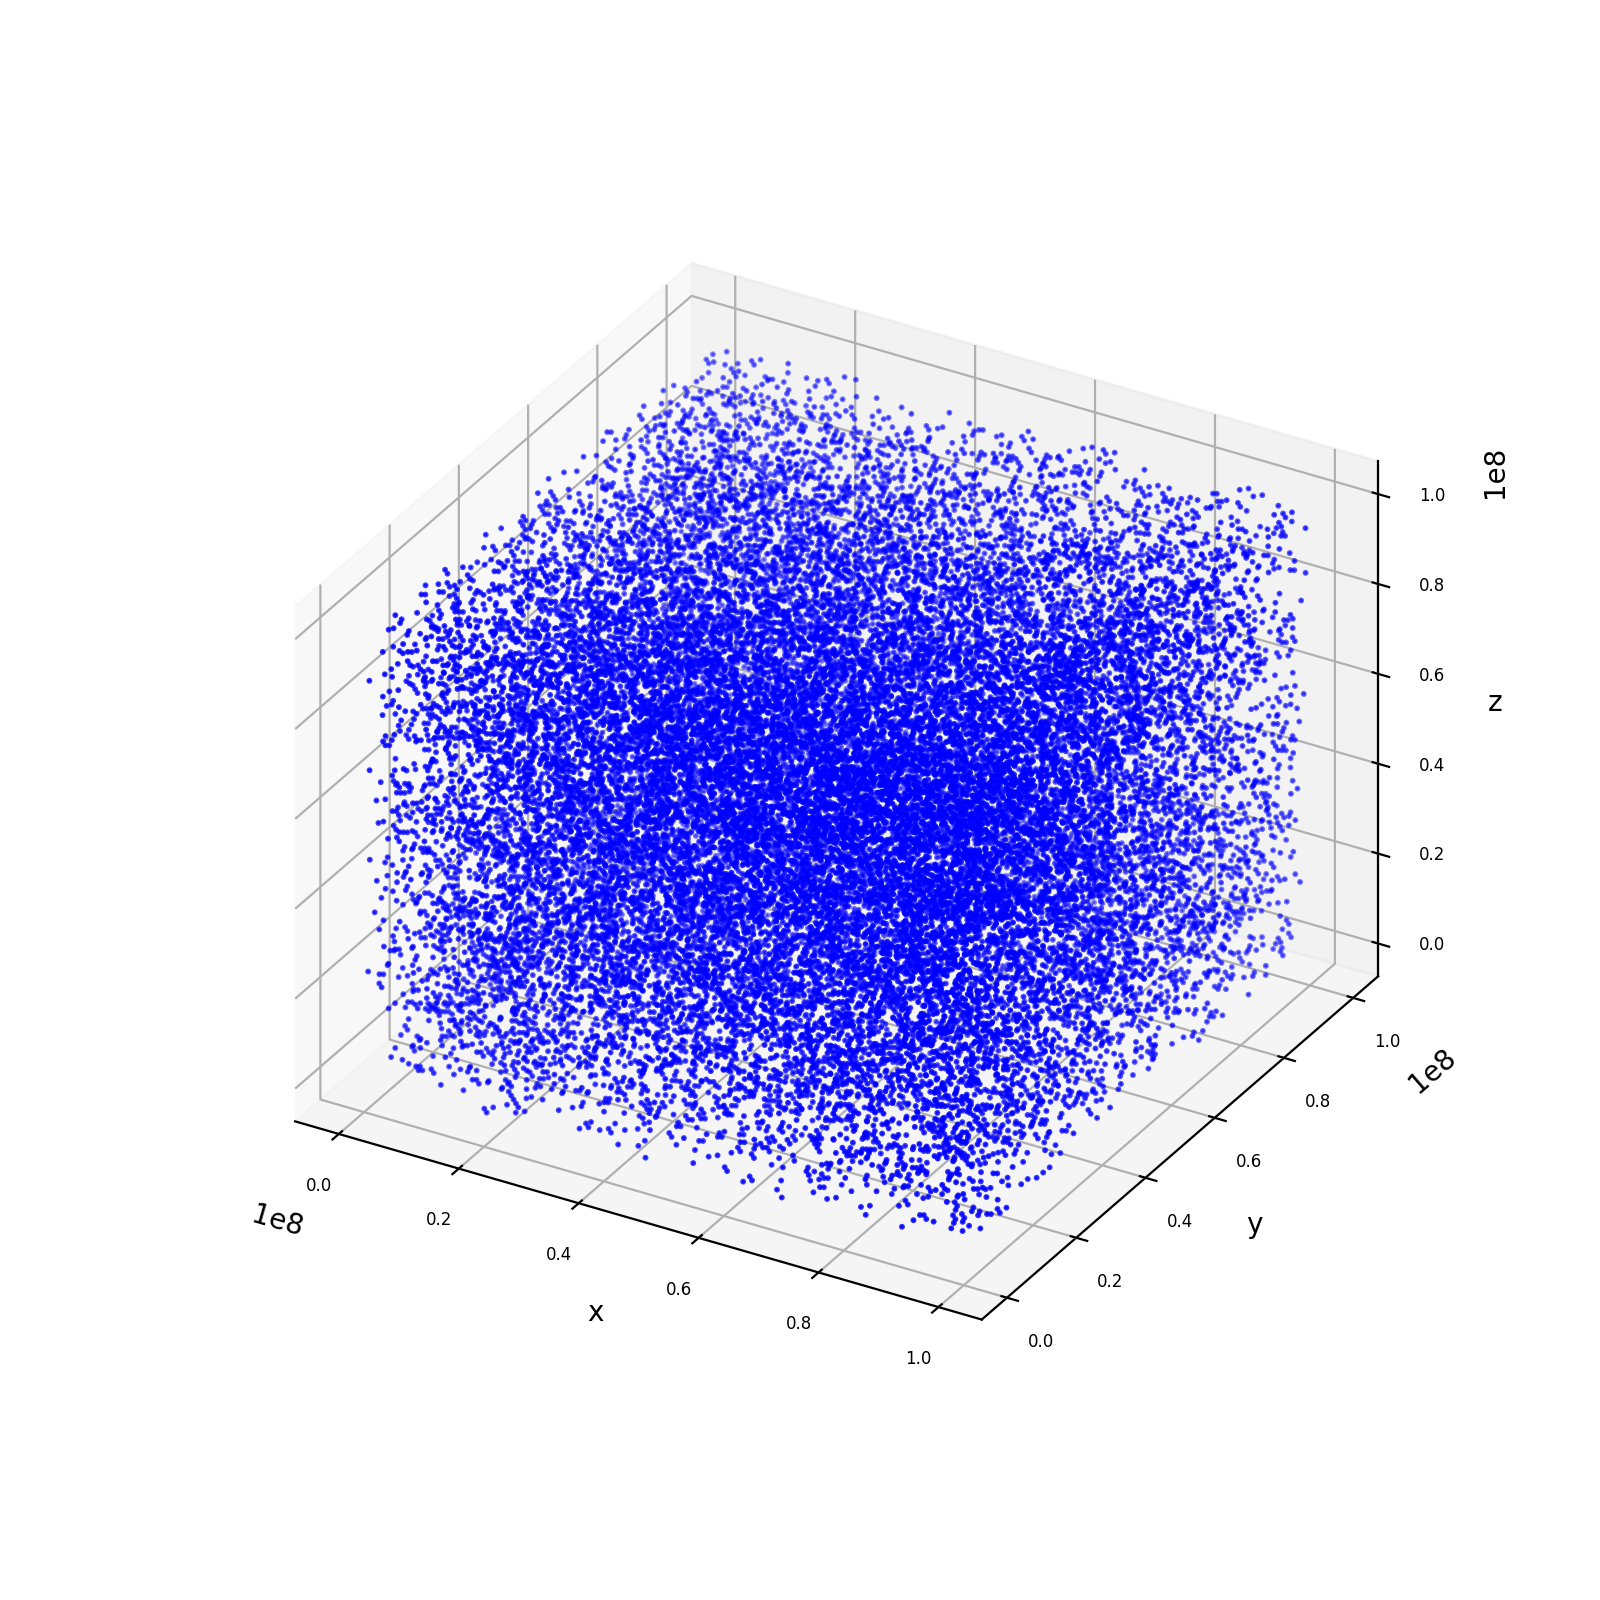

In [6]:
#python random numbers
rand_points_pyth = np.random.rand(len(rand_points),3)
fig = plt.figure()
ax = plt.axes(projection='3d',proj_type = 'ortho')
ax.scatter3D(rand_points[:,0], rand_points[:,1], rand_points[:,2],marker='.',color='blue',s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_size_inches(8,8)

After looping around different angles for a long time we don't see any patterns/lines/planes except uniformly distributed triples. So, by default of not being able to prove by contradiction (i.e. seing a pattern), I think we can be fairly confident to say that we cannot see the same effect with python's PRNG.

## PROBLEM 2


We want to generate exponential deviates using the rejection method with either a Lorentzian, a Gaussian or a power law.

The idea of the rejection method is as follows:

Suppose we want to generate deviates from a distribution given by $f(x)$. We can use a good comparison function $p(x)$ which has a finite area and bounds $f(x)$ by above (i.e. the distribution of $p(x)$ is never less or never intersects $f(x)$). Now, $p(x)$'s cumulative density function needs to be analytically inversable to be able to draw deviates from it. Then, we can generate a deviate from $p(x)$, $x'$, and a uniform random number, $y'$ (which can be viewed as the corresponding "y deviate"); if $y'$ is less or equal to the ration of $\frac{f(x')}{p(x')}$ then we have $x'$ as a deviate of the distribution $f(x)$.

Now, we need to choose between the Gaussian, Lorentzian and Power Law for the comparison function $p(x)$ of the 
exponential ($f(x)$ here)

* If we equate a Gaussian to the exponential function, we always have a solution, meaning that the two functions intersect. This means that we should not use a Gaussian as the comparison function since it does not bound the exponential. 

* For a power law, $P(x) = x^{-a}$, we do not have a finite area, i.e. $\int_0^{+\infty}x^{-a}$ is undefined, and since we need a finite area for the comparison function, we should not use it (I am not so so sure about this part)

This leads to using a Lorentz as the comparison function $p(x)$ to draw deviate from the exponential. Indeed since Lorentz goes as $\frac{1}{1+x^2}$ which always decays slower than the exponential, the Lorentz is a suitable function to draw exponential deviates using the rejection method.

So, we want to first be able to draw random numbers from a Lorentz distribution.

The centered at 0 Lorentz is given by

$L(x,a) = \frac{a}{1+(ax)^2}$. We first normalize it, where $\int_0^\infty\frac{a}{1+(ax)^2}=\frac{\pi}{2}$ such that 

$\text{pdf} _L(x) = \frac{2a}{\pi(1+(ax)^2)}$. 

The transform method requires to simply take the cdf of the pdf and then inverse it to get x deviates:

$\int_0^x\frac{2a}{\pi(1+(ax)^2)} = \frac{2}{\pi}\text{arctan}(ax)$ $\implies \left[\frac{2}{\pi}\text{arctan}(ax)\right]^{-1} = \frac{1}{a}\text{tan}\left(\frac{\pi x}{2}\right)$

So our function to draw random numbers from a Lorentz distribution is given by $\frac{1}{a}\text{tan}\left(\frac{\pi x}{2}\right)$.

From the rejection method, the "ideal" ratio of accepted deviates is given the ratio of the area of $f(x)$ to the area of $p(x)$ (not normalized). In other words, $\text{acc}_{\text{rate}} = \frac{\int_0^\infty e^{-ax}}{\int_0^\infty \frac{a}{(1+(ax)^2)}}dx = \frac{2}{\pi a}$

<IPython.core.display.Javascript object>


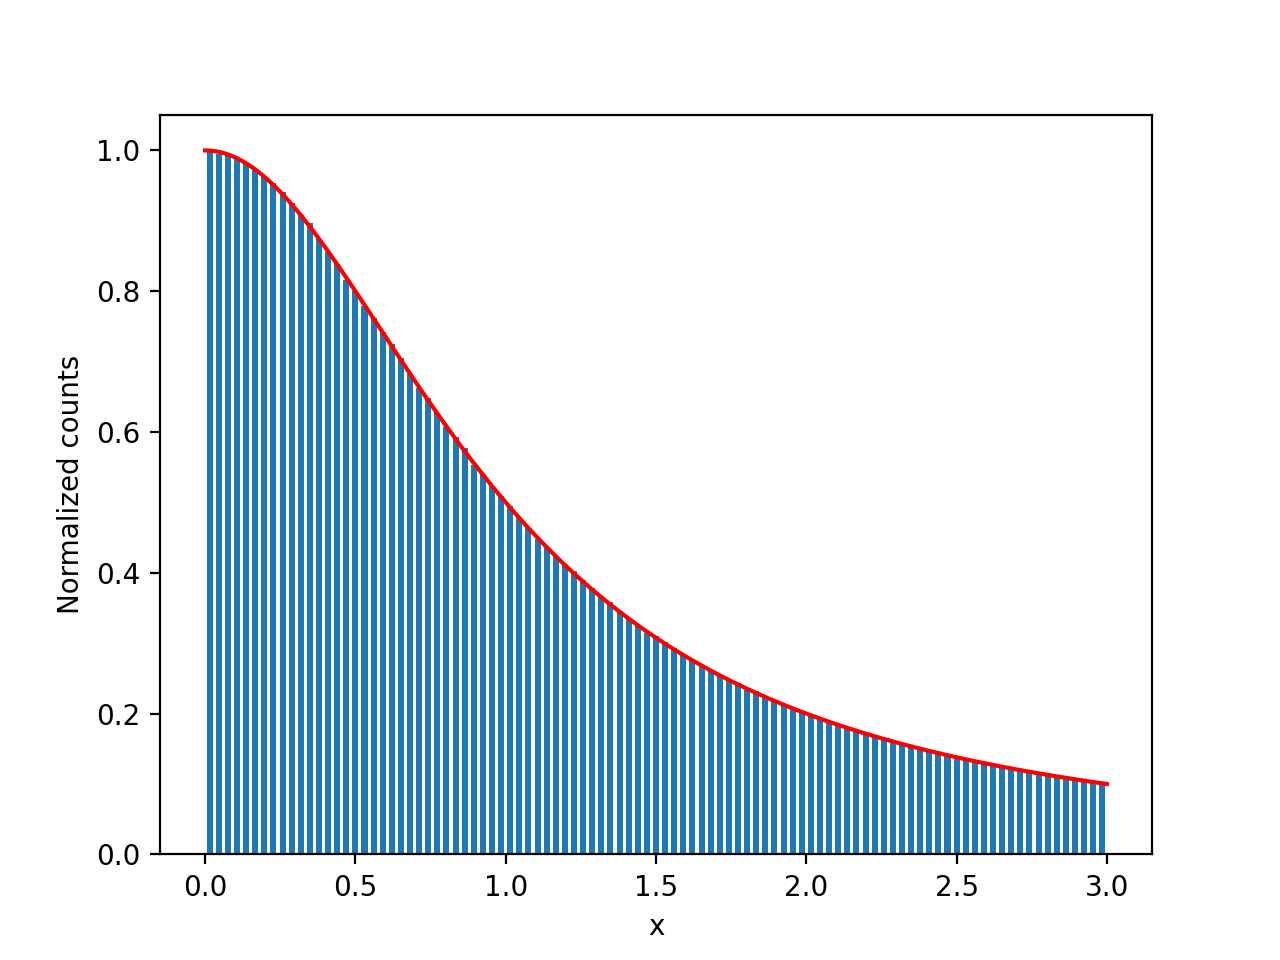

Text(0, 0.5, 'Normalized counts')

In [7]:
def lorentz(x,a): #Lorentz centered at 0, scaled by 1/a
    return a/(1+(a*x)**2)

def inv_cdf_lorentz(x,a): #transform function for drawing random numbers with Lorentz distribution
    return np.tan(x*np.pi/2)*(1/a)

#Let's first see if we can generate random numbers with Lorentz distribution
n=10000000
a=1

x = np.random.rand(n)
x_use = inv_cdf_lorentz(x,a)
aa,bb=np.histogram(x_use,np.linspace(0,3,100))
b_cent=0.5*(bb[1:]+bb[:-1])
x=np.linspace(0,3,1000)
plt.figure()
plt.bar(b_cent,aa/np.max(aa)*a,0.02)
plt.plot(x,lorentz(x,a),'-r')
plt.xlabel('x')
plt.ylabel('Normalized counts')



Indeed, we see that the lorentz deviates match very well with the lorentz distribution function! We can now use the rejection method to draw exponential deviates.

<IPython.core.display.Javascript object>


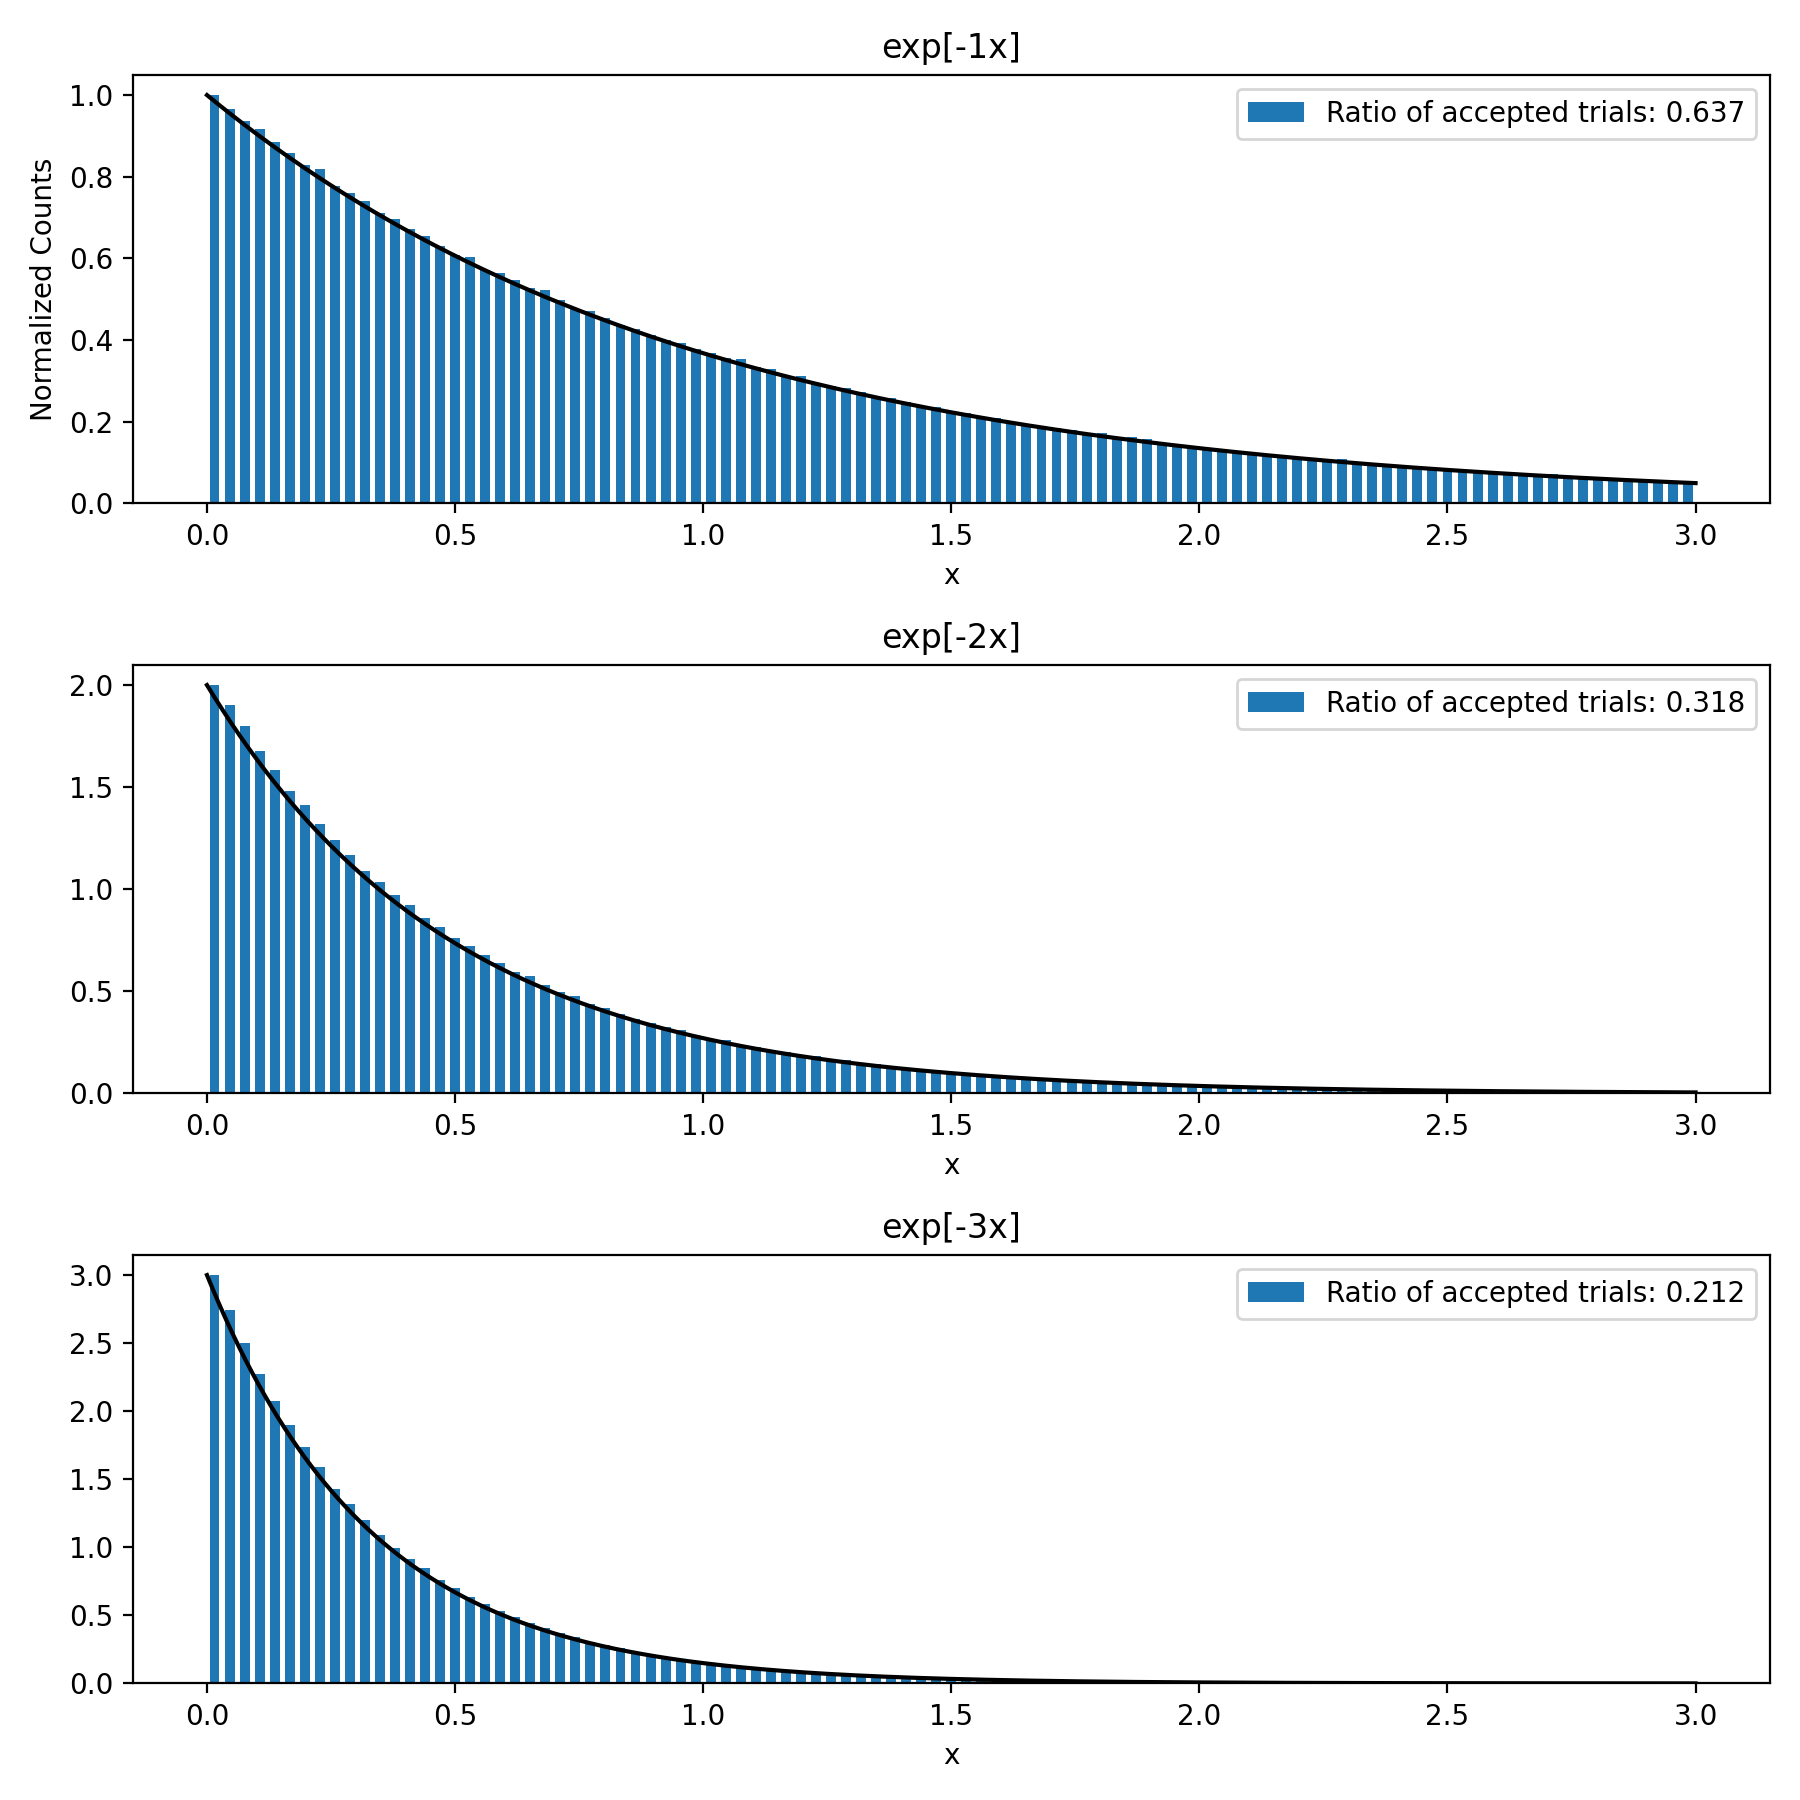

In [10]:
def exp_deviate(x,a):
    return a*np.exp(-x*a) #normalized exponential pdf

def rejection_exp(n,a,bf_inv,bf):
    
    n_accept=0
    n_try=0 #variable to then calculate the ratio of accepted steps
    x_accept = []
    while n_accept<n:
        x_uniform = np.random.rand() #uniform rand variable
        x_transform = bf_inv(x_uniform,a) #transform to lorentz deviate
        y_uniform = np.random.rand()*a #uniform rand variable (scaled by a)
        
        if y_uniform <= exp_deviate(x_transform,a)/(bf(x_transform,a)): #rejection method True-->accept
            x_accept.append(x_transform)
            n_accept += 1
        n_try += 1

    
    return np.array(x_accept),n/n_try
        
n = 1000000  
xmin=0
xmax=3
x = np.linspace(xmin,xmax,10000)
fig,axs = plt.subplots(3)
for i in range(3):
    a=i+1
    exp_true = exp_deviate(x,a)

    x_exp,n_ratio = rejection_exp(n,a,inv_cdf_lorentz,lorentz)
    aa,bb=np.histogram(x_exp,np.linspace(xmin,xmax,100))
    b_cent=0.5*(bb[1:]+bb[:-1])
    
    axs[i].bar(b_cent,aa/np.max(aa)*a,0.02,label='Ratio of accepted trials: {}'.format(f'{n_ratio:.3}'))
    axs[i].plot(x,exp_true,'-',color='k')
    
    axs[i].legend()
    axs[i].set_xlabel('x')
    axs[i].set_title('exp[-{}x]'.format(a))
    
axs[0].set_ylabel('Normalized Counts')
fig.set_size_inches(9,9)
fig.tight_layout()


From the plots we can see how everything went as planned! We have a matching exponential distribution and the ratio of accepted trials is approximately $\frac{2}{\pi a}$! :)

## Problem 3: RATIO OF UNIFORMS

Now we want to use the method of the ratio of uniforms. The general idea is to map the number line to a box. We know that this works since the Jacobian is a constant!

We take the (u,v) plane where $0<u<\sqrt{\text{pdf}(v/u)}$, sample $u,v$ uniformly in the given region and then return $v/u$ if $u<\sqrt{\text{pdf}(v/u)}$.

For the exponential, we thus have

$0<u<\sqrt{\text{e}^{-v/u}} \implies v <= 2u\text{ln}(u)$ which gives the upper bound of the region (where 0 is the lower bound). So, we use this and apply the ratio of uniforms method.

<IPython.core.display.Javascript object>


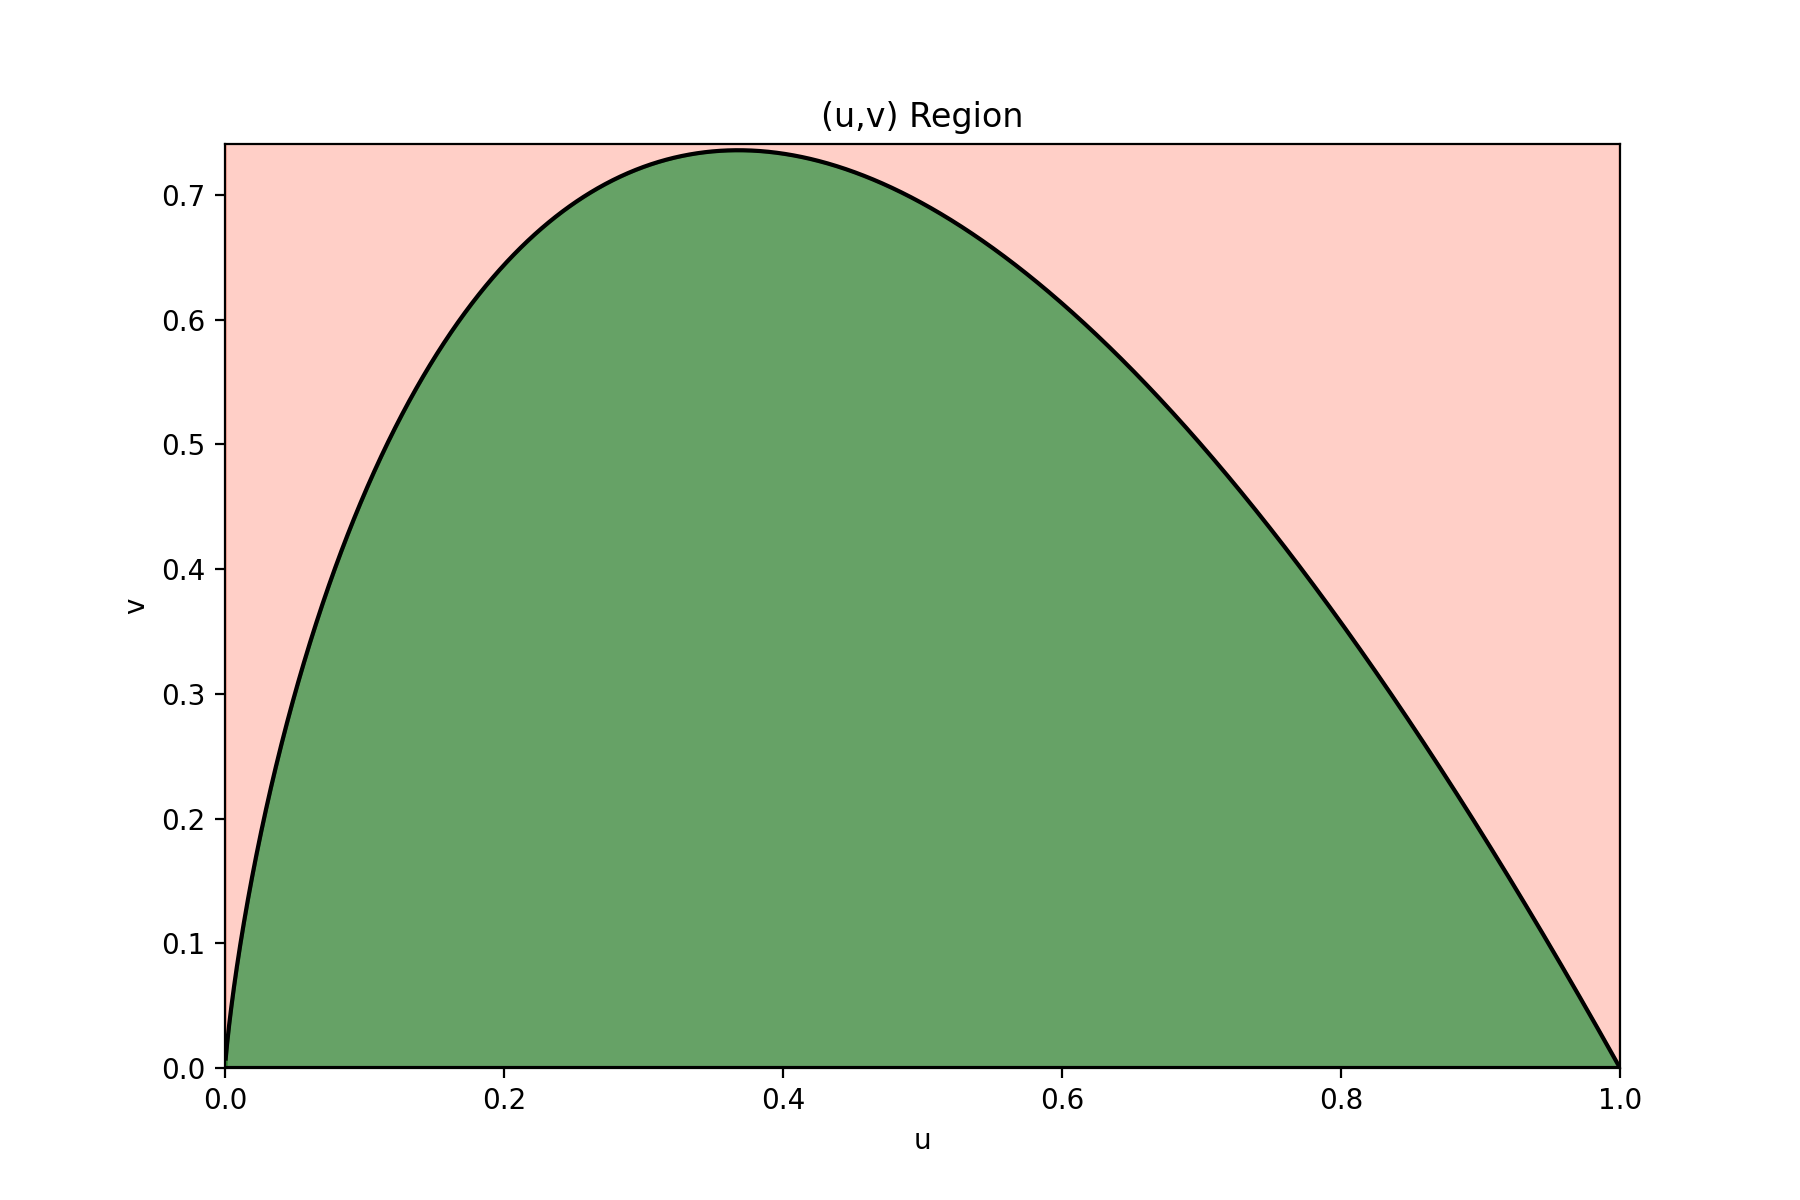

In [11]:
#First we can plot our region

u=np.linspace(0,1,2001)
u=u[1:]

v=2*u*-np.log(u)

fig = plt.figure()
plt.plot(u,v,'k')
plt.fill_between(u,v,color='darkgreen',alpha=0.6)
plt.fill_between(u,v,1,color='tomato',alpha=0.3)
plt.ylim(0,v.max()+0.005)
plt.xlim(0,1)
plt.hlines(0,0,1,'k')
plt.xlabel('u')
plt.ylabel('v')
plt.title('(u,v) Region')
fig.set_size_inches(9,6)


Above is the $(u,v)$ region from which we draw $u,v$ uniformly.

In [12]:
def ratio_uniforms(N):
    u=np.linspace(0,1,2001)
    u=u[1:]
    v=2*u*-np.log(u) #upper bound
    v_max = v.max() #approx max value that v can take
    
    n_accept = 0
    n_try = 0
    deviate = []
    while n_accept<N: #loop until we have N deviates
        u = np.random.rand()
        v = np.random.rand()*v_max
        r = v/u #ratio
        if u<=np.exp(-r/2): #if true --> accept deviate
            deviate.append(r)
            n_accept += 1
        n_try += 1
    
    return np.array(deviate),N/n_try
N=10000000
exp_dev_ratio,n_accepted= ratio_uniforms(N)

<IPython.core.display.Javascript object>


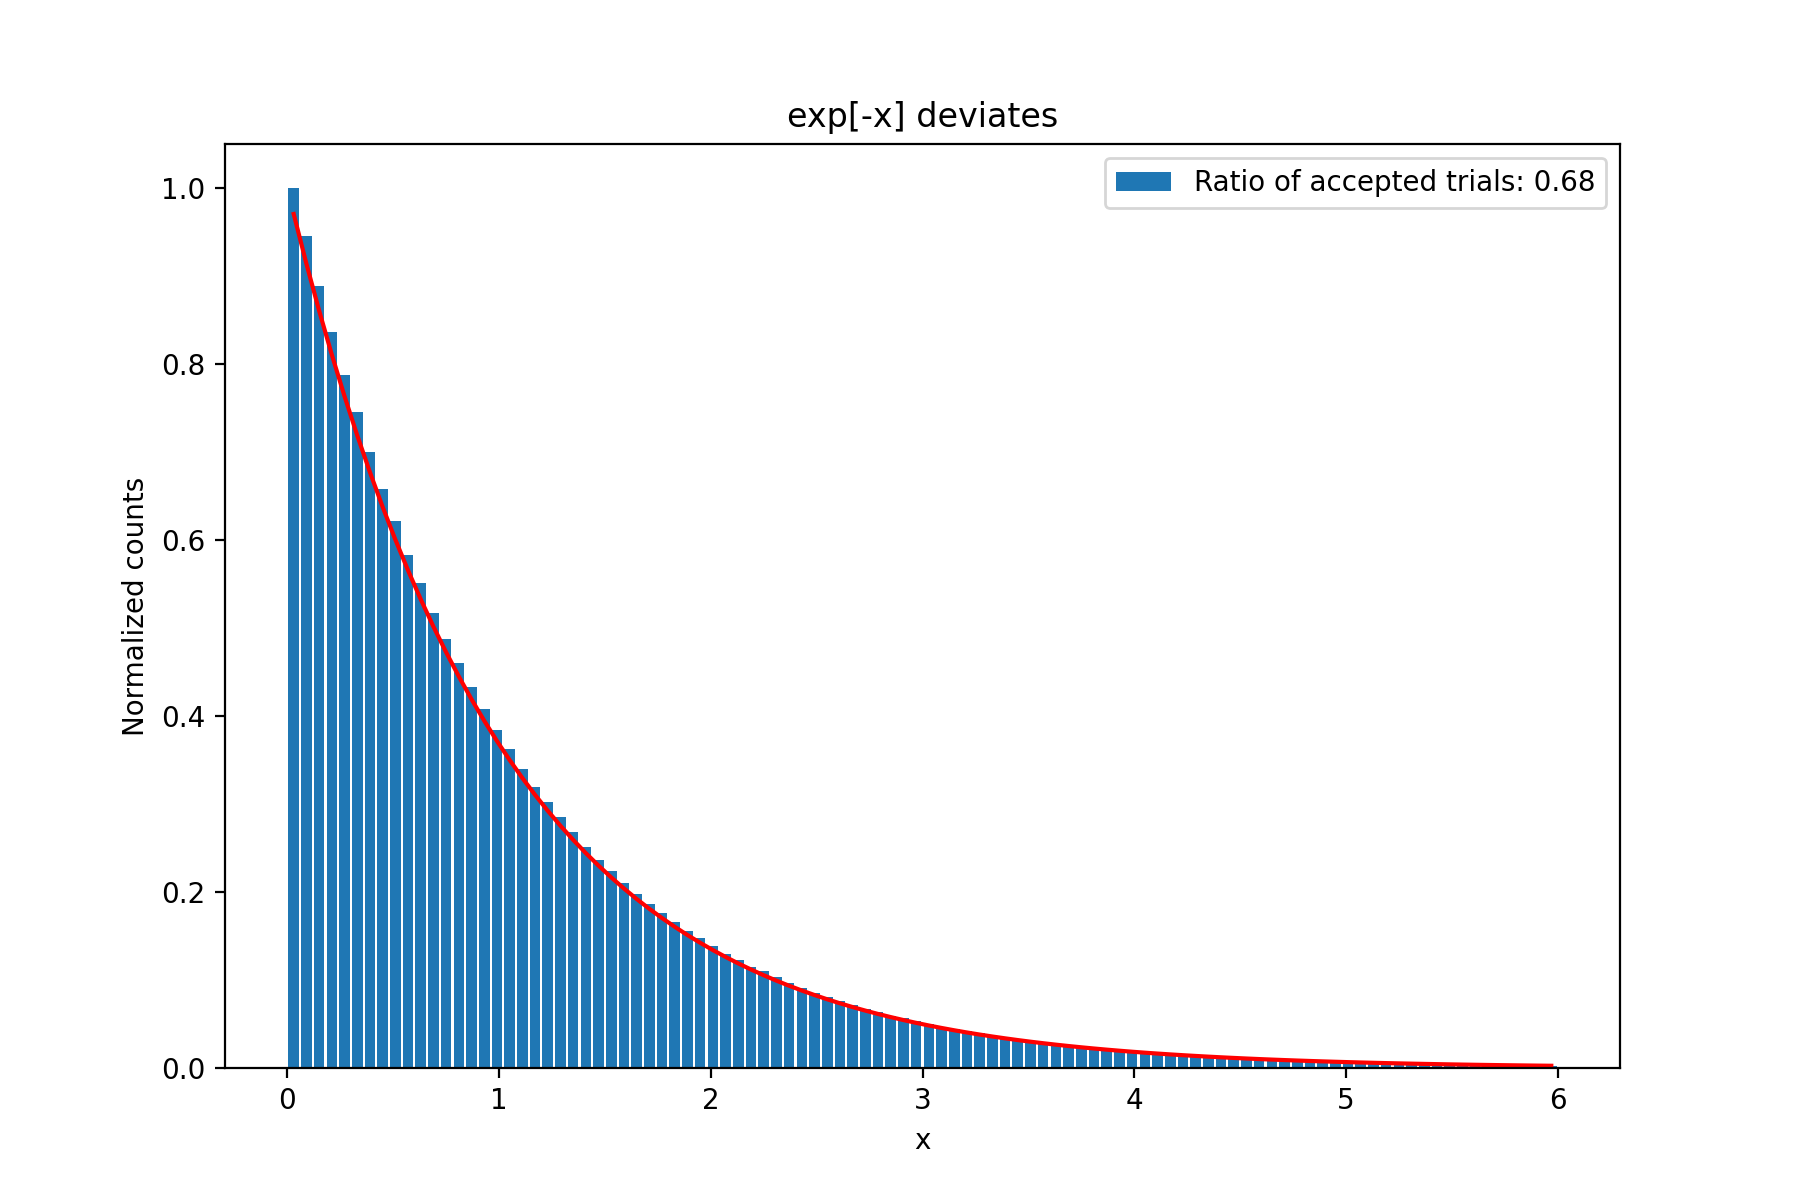

In [13]:
a,b=np.histogram(exp_dev_ratio,100,range=(0,6))
bb=0.5*(b[1:]+b[:-1])
fig = plt.figure()
plt.bar(bb,a/np.max(a),0.05,label='Ratio of accepted trials: {}'.format(f'{n_accepted:.3}'))
plt.plot(bb,exp_deviate(bb,1),'r')
plt.legend()
plt.xlabel('x')
plt.ylabel('Normalized counts')
plt.title('exp[-x] deviates')
fig.set_size_inches(9,6)

So we see the the exponential deviates with the ratio of uniforms match the exponential distribution! The method is slightly more efficient than the rejection method (by about 5%) so this is the most efficient method between the two so far!